In [ ]:
from datasets import load_dataset
import pandas as pd
import re
import matplotlib.pyplot as plt

ds = load_dataset("yassiracharki/Amazon_Reviews_for_Sentiment_Analysis_fine_grained_5_classes")


In [ ]:
# Convert the 'train' split to a pandas DataFrame
df_train = ds['train'].to_pandas()
df_test = ds['test'].to_pandas()

## Explore the Dataset

In [ ]:
df_train.head()

In [ ]:
# Check dataset size
print(f"Number of samples: {len(df_train)}")

# Check for missing values
print(df_train.isnull().sum())

# Check class distribution
print(df_train['class_index'].value_counts(normalize=True))


There are 3 million data points. Importantly there are no missing values in class or text. The 188 missing values in title section will not harmfull for our model.

In [ ]:
df_test.info()

The test dataset gas 650000 data points, which we will keep for the testing the model.

## Cleaning the text

In [ ]:
# Drop rows with missing review_text or class_index
df_train = df_train.dropna(subset=['review_text', 'class_index'])

# Optional: fill missing titles with empty string
df_train['review_title'] = df_train['review_title'].fillna("")
df_test['review_title'] = df_test['review_title'].fillna("")

# Combine title and text into one column
df_train['text'] = df_train['review_title'] + ": " + df_train['review_text']

# Basic text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

# Apply cleaning
df_train['clean_text'] = df_train['text'].apply(clean_text)




In [ ]:
# drop review_title and review_text and text
df_train = df_train.drop(columns=['review_title', 'review_text', 'text'])

# rename class_index to label and clean_text to text
df_train = df_train.rename(columns={'class_index': 'label', 'clean_text': 'text'})
df_test['text'] = df_test['review_text']
df_test['label'] = df_test['class_index']

In [ ]:
df_test.head()

In [ ]:
# find the length of longest review_text and review_title of train and test df
def find_max_length(df, column):
    max_length = df[column].apply(lambda x: len(re.findall(r'\w+', x))).max()
    return max_length
max_length_train_clean_text = find_max_length(df_train, 'text')
max_length_test_review_text = find_max_length(df_test, 'review_text')
max_length_test_review_title = find_max_length(df_test, 'review_title')
print(f"Max length of clean_text in train: {max_length_train_clean_text}")
print(f"Max length of review_text in test: {max_length_test_review_text}")
print(f"Max length of review_title in test: {max_length_test_review_title}")

Therefore minimum 512 length of context window is required in our transformer to process each datapoint alone

NameError: name 'plt' is not defined

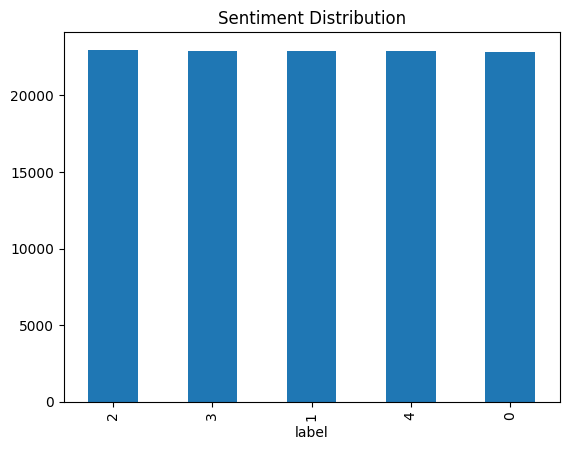

In [4]:
df_train['label'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.show()


The dataset consists of review scores, which is 5 different values form 1-5, 5 is the best. And those are well distributed closely 20% percent for each level

## Try RoBERTa based classification model to classify amazon reviews

In [ ]:
from transformers import RobertaConfig, RobertaModel

In [ ]:
configuration = RobertaConfig()
print(configuration)

In [ ]:
model = RobertaModel(configuration)
print(model)

Based on the model configs and the architecture there are few observations.
1. the embedding lookup table is 50265x768, which means this accepts 50265 of discrete tokens and embedded them with the 768 vector.
2. Max poisitional embedding is 512, therefore it implies that the maximum input tokens is 512 for the model, at least for the existing traiing configs it followed.
3. 12 encoder transformer blocks which transform the input embeddings through 12 levels


To input the raw data into model, we need to use a tokenizer to represent our natural language inputs by integer. In RoBERTa, they use byte pair encoding which is similar to GPT-2 tokenizer.
So after taking the raw text, the tokenizer outputs the sequence of integers, which become thr onput to the Language Model

In [ ]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("FacebookAI/roberta-base")
model = RobertaModel.from_pretrained("FacebookAI/roberta-base")

In [ ]:
tokenizer("Hello world")

In this assignment, we do not initiate all the parameters (weights) of the models, and train from scratch. Instead we load the pretrained weights from the trained model. -- roberta-base model.
The bare RoBERTa Model transformer outputting raw hidden-states without any specific head on top.

In [ ]:
import torch
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
inputs.input_ids, inputs.input_ids.shape

We convert the integer list intp pytorch tensor, as the model is built with pytorch and those accepts only tensor inputs.
Tensors are similar to multi deimensional arrays, which are optimized for numerical methods and gpu

In [ ]:
model = RobertaModel.from_pretrained("FacebookAI/roberta-base")
# n of paramas
print(f"Number of parameters: {model.num_parameters() / 1e6:.2f}M")
outputs = model(**inputs)


Model has around 124M parametes

In [ ]:
last_hidden_state_shape = outputs.last_hidden_state.shape
pooler_output_shape = outputs.pooler_output.shape
print(f"Last hidden state shape: {last_hidden_state_shape}")
print(f"Pooler output shape: {pooler_output_shape}")

As we can see the models final layers, the hidden states are one hidden state representation for each input token,
and the pooler output is the first hidden state vector.

But, in this assignment we are planning to use differnt pooling stategies like mean/max and finally we may plan to compare the results, if possible the pooler as well.

## Building the RoBERTa Sentiment Clasifier

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizerFast
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tqdm import tqdm


# Define the classifier model
class MaxPoolRobertaClassifier(nn.Module):
    """
    A simple classifier using RoBERTa with max pooling.
    This initiates the RoBERTa model and adds a classifier head on top.
    The RoBERTa model is frozen to prevent training.
    The classifier head consists of a series of linear layers with ReLU activations and dropout for regularization.
    
    Args:
        num_labels (int): The number of output labels for the classification task.
    """
    def __init__(self, num_labels=5):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        # Freeze RoBERTa encoder
        for param in self.roberta.parameters():
            param.requires_grad = False
        
        # classifier head
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )
    
    def forward(self, input_ids, attention_mask, labels=None):
        """
        Forward pass through the model.
        
        Args:
            input_ids (torch.Tensor): Input token IDs.
            attention_mask (torch.Tensor): Attention mask to avoid padding tokens.
        
        Returns:
            torch.Tensor: Logits for each class.
        """
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # [B, L, H]
        
        # Mask padding tokens for pooling
        mask = attention_mask.unsqueeze(-1).expand(hidden_states.size())
        masked_hidden = hidden_states.masked_fill(mask == 0, -1e9)
        
        # Max pooling across token dimension
        pooled_output = torch.max(masked_hidden, dim=1).values  # [B, H]
        
        # Feed to classifier head
        logits = self.classifier(pooled_output)

        return logits

### Building the data loader

To train the model (the prediction head) we need to input the traininig data we have in an efficient way. So that we use pytorch inherent Dataset class and build out loaders

In [ ]:
# Create a custom dataset for Amazon reviews
class AmazonReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Return the encoded input and label
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:

# Training function
def train_model(model, train_loader, val_loader=None, epochs=5, learning_rate=2e-5):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Move model to device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Training loop
    best_val_accuracy = 0.0
    
    # Set up learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=1, verbose=True
    )
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        all_preds = []
        all_labels = []
        
        # Progress bar for training
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            print(f"input_ids shape: {input_ids.shape}")
            attention_mask = batch['attention_mask'].to(device)
            print(f"attention_mask shape: {attention_mask.shape}")
            labels = batch['label'].to(device)
            print(f"labels shape: {labels.shape}")
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Calculate loss - check for nan values and shapes
            try:
                # Print shape information for debugging
                if torch.isnan(outputs).any():
                    print(f"Warning: outputs contain NaN values")
                
                # Make sure labels are in the correct range for the model's output classes
                if torch.max(labels) >= outputs.size(1):
                    print(f"Error: Labels out of range. Max label: {torch.max(labels).item()}, Output size: {outputs.size(1)}")
                    continue
                
                loss = criterion(outputs, labels)
                
                # Check for NaN loss
                if torch.isnan(loss):
                    print("Warning: NaN loss detected, skipping batch")
                    continue
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
            except RuntimeError as e:
                print(f"Error in batch: {e}")
                continue
            
            # Track loss and predictions
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({'loss': train_loss / (progress_bar.n + 1)})
        
        # Calculate training accuracy
        train_accuracy = accuracy_score(all_labels, all_preds)
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Training Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}')
        
        # Validation if provided
        if val_loader:
            val_loss, val_accuracy, val_report = evaluate_model(model, val_loader, criterion, device)
            print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
            print(val_report)
            
            # Save best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(model.state_dict(), 'best_roberta_classifier.pt')
                print(f'Model saved with accuracy: {val_accuracy:.4f}')
    
    return model

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = val_loss / len(data_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_report = classification_report(all_labels, all_preds)
    
    return val_loss, val_accuracy, val_report

In [ ]:
# Prediction function
def predict(model, text, tokenizer, device):
    # Tokenize the text
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, 1)
    
    return preds.item()


## Ctd.

In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train = df_train.groupby('label').apply(lambda x: x.sample(frac=0.05, random_state=42)).reset_index(drop=True)

/tmp/ipykernel_1977387/2007099206.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby('label').apply(lambda x: x.sample(frac=0.05, random_state=42)).reset_index(drop=True)


In [3]:
data_train = df_train[['text', 'label']]
data_test = df_test[['text', 'label']]

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch


In [6]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import RobertaForSequenceClassification

tokenizer = RobertaTokenizerFast.from_pretrained("FacebookAI/roberta-base")
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=5
)

/home/AD/sachith/.conda/envs/blt_250329/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model = model.to('cuda')

In [8]:
sample_data = ["I am playing", "I am sachith"]
tokenizer(sample_data, padding=True, truncation=True, max_length=512)

{'input_ids': [[0, 100, 524, 816, 2, 1, 1], [0, 100, 524, 579, 1488, 3432, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1]]}

In [9]:
from torch.utils.data import Dataset, DataLoader
# Create a custom dataset for Amazon reviews
class AmazonReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Return the encoded input and label
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [10]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [11]:
train_dataset = AmazonReviewDataset(data_train, tokenizer)
val_dataset = AmazonReviewDataset(data_test, tokenizer)

In [12]:
from transformers import TrainingArguments, Trainer
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    per_device_train_batch_size=4

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/home/AD/sachith/.conda/envs/blt_250329/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:37: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 3 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: e240203 (e240203-nanyang-technological-university-singapore) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/AD/sachith/.conda/envs/blt_250329/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
